In [71]:
import os, glob, time, sys
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter

In [105]:
class DataLife:
    
    def __init__(self, G=None):
        self.utils = Utils
        self.G = G
    
    def max_volume_path(self, G, weight='volume'):
        """Returns the edge tuples by identifying maximum volume in a 
        directed acyclic graph (DAG).

        If `G` has edges with `volume` attribute the edge data are used as
        weight values.

        Parameters
        ----------
        G : NetworkX DiGraph
            A directed acyclic graph (DAG)

        weight : str, optional
            Edge data key to use for weight

        Returns
        -------
        list
            edge tuples
        """
        path = nx.dag_longest_path(G, weight)
        path_edges = list(zip(path,path[1:]))
        return path_edges

    
    def mismatch_rate(self, G, rate='rate', threshold=.9):
        """Returns the python dictionary by identifying mismatched data rates in a 
        directed acyclic graph (DAG).

        If `G` has edges with `rate` attribute the edge data are used as
        weight values.

        Parameters
        ----------
        G : NetworkX DiGraph
            A directed acyclic graph (DAG)

        rate : str, optional
            Edge data key to use for weight
            
        threshold: float, optional
            value between 0 to 1 to cut off mismatch, default .9

        Returns
        -------
        dictionary
            key: 
                node name
            value:
                in_rate: float, incoming data rate (avg.)
                out_rate: float, outgoing data rate (avg.)
                in_edges: list, incoming edge tuples
                out_edges: list, outgoing edge tuples
        """
        res = {}
        for n, attr in G.nodes(data=True):
            if  'ntype' in attr and attr['ntype'] == 'task':
                continue
            in_edges = [x for x in G.in_edges(n, data=True)]
            out_edges = [x for x in G.out_edges(n, data=True)]
            in_rate_mean = np.mean([attr[rate] for u, v, attr in (in_edges)])
            out_rate_mean = np.mean([attr[rate] for u, v, attr in (out_edges)])
            if np.isnan(in_rate_mean) or np.isnan(out_rate_mean):
                continue

            if in_rate_mean > out_rate_mean:
                if (out_rate_mean / in_rate_mean) < threshold:
                    continue
            else:
                if (in_rate_mean / out_rate_mean) < threshold:
                    continue
            res[n] = {'in_rate': in_rate_mean,
                     'out_rate': out_rate_mean,
                     'in_edges': [(u, v) for u, v, a in in_edges],
                      'out_edges': [(u, v) for u, v, a in out_edges]}
        return res

    def leaf_file_node(self, G, attr_name='volume', partial=.0):
        """Returns the python dictionary by identifying non-use of dataset in a 
        directed acyclic graph (DAG).

        If `G` has edges with `volume` attribute the edge data are used as
        weight values.

        Parameters
        ----------
        G : NetworkX DiGraph
            A directed acyclic graph (DAG)
            
        partial : float, optional
            value between 0 and 1 to detect subset-use, default .0

        Returns
        -------
        dictionary
            key:
                node name
            value:
                out_edges: edge tuples
                volume_used: total size of subset data (sum)
        """
        res = {}
        vol = attr_name
        for n, attr in G.nodes(data=True):
            if  'ntype' in attr and attr['ntype'] == 'task':
                continue
            out_edges = G.out_edges(n)
            if len(out_edges) == 0:
                # OutEdgeDataView([])
                try:
                    res[n]['out_edges'] = out_edges
                    res[n]['volume_used'] = 0
                except:
                    res[n] = {'out_edges': out_edges,
                              'volume_used' : 0 }
            elif partial:
                out_edges = G.out_edges(n, data=True)
                out_vol_sum = sum([attr[vol] for u, v, attr in (out_edges)])
                if out_vol_sum / attr[vol] < partial:
                    try:
                        res[n]['out_edges'] = out_edges
                        res[n]['volume_used'] = out_vol_sum
                    except:
                        res[n] = {'out_edges': out_edges,
                                 'volume_used': out_vol_sum}
                    
        return res
    
    def partial_leaf_file_node(self, G, attr_name='volume', partial=.5):
        """Returns the python dictionary by identifying non-use of dataset in a 
        directed acyclic graph (DAG).

        If `G` has edges with `volume` attribute the edge data are used as
        weight values.

        Parameters
        ----------
        G : NetworkX DiGraph
            A directed acyclic graph (DAG)
            
        partial : float, optional
            value between 0 and 1 to detect subset-use, default .5

        Returns
        -------
        dictionary
            key:
                node name
            value:
                out_edges: edge tuples
                volume_used: total size of subset data (sum)
        """        
        return self.leaf_file_node(G, attr_name, partial)
        
    def spatial_temporal_locality(self, G):
        """
        requres block ids (offset) to align tasks in order
        TBD
        
        
        """
        pass
        
    
    def producer_consumer_tasks(self, G):
        """Returns all paths in the graph G between producer and consumer 
        task nodes.

        A producer-consumer path is a path between source node (producer) 
        and target node (consumer) with no repeated nodes.


        Parameters
        ----------
        G : NetworkX DiGraph
            A directed acyclic graph (DAG)

        Returns
        -------
        list
            path
        """
        res = []
        for n, attr in G.nodes(data=True):
            if  'ntype' in attr and attr['ntype'] != 'task':
                continue
            producer_n = n
            data_n = [x[1] for x in G.edges(producer_n)]
            consumer_n = set()
            for x in data_n:
                consumer_n.update(set([x[1] for x in G.edges(x)]))
            for consumer in consumer_n:
                paths = [x for x in nx.all_simple_paths(G, producer_n, consumer, cutoff=2)]
                res += paths
        return res    

In [96]:
metric = 'weighted_access_size'
metric_ = metric + ' (sum)'

filtered_file_ext = ['h5', 'pt', 'fits']

class Utils:
    
    @staticmethod
    def stat_to_df(fname, data_mode="individual"):
        if data_mode == "combined":
            df = pd.read_csv(fname, sep=' ', names=['fname', 'offset', 'access_size', 'extra1', 'extra2'], skiprows=0)
        else:
            df = pd.read_csv(fname, sep=' ', names=['block_idx', 'frequency', 'access_size'], skiprows=1)            
        return df
    
    @staticmethod
    def read_tazer_stats(dpath, summary=True, data_mode="individual"):

        agg_sum = {'frequency':'sum', 'access_size':'sum', 'weighted_access_size': 'sum'}
        agg_avg = {'frequency':'mean', 'access_size':'mean', 'weighted_access_size': 'mean'}
        agg_sum_rename = {'frequency': 'frequency (sum)', 
                          'access_size': 'access_size (sum)', 
                          'weighted_access_size': 'weighted_access_size (sum)'}
        agg_avg_rename = {'frequency': 'frequency (avg)', 
                          'access_size': 'access_size (avg)',
                          'weighted_access_size': 'weighted_access_size (avg)'}

        df_all = {}
        
        if data_mode == "individual":
            suffix = "/*/*_stat"
        elif data_mode == "combined":
            suffix = "/*.txt"

        for fpath in glob.glob(dpath + suffix):

            # ignore trace stats but for r/w stat
            if fpath[-10:] == "trace_stat":
                continue
            df = Utils.stat_to_df(fpath, data_mode)
            if df.empty is True:
                continue

            if data_mode == "combined":
                task_name = os.path.basename(fpath).split("_")[1].split(".")[0]
                df_all[task_name] = {}
                if summary is True:
                    df_sum = df.groupby('fname').sum()
                    df_avg = df.groupby('fname').mean()
                    for io_fname, row in df_sum.iterrows():
                        df_all[task_name][io_fname] = row
                else:
                    for io_fname, data in df.groupby('fname'):
                        df_all[task_name][io_fname] = data
            else:
                task_name = os.path.basename(os.path.dirname(fpath))
                stat_filename = os.path.basename(fpath)
                if summary is True:
                    df['weighted_access_size'] = df['frequency'] * df['access_size']
                    series = df.agg(agg_sum)
                    df_sum = pd.DataFrame(series).transpose().rename(columns=agg_sum_rename)
                    series = df.agg(agg_avg)
                    df_avg = pd.DataFrame(series).transpose().rename(columns=agg_avg_rename)
                    df = pd.concat([df_sum, df_avg], axis=1)
                if task_name in df_all:
                    if stat_filename in df_all[task_name]:
                        print(fname, "==duplicate==")
                    df_all[task_name][stat_filename] = df
                else:
                    df_all[task_name] = {stat_filename: df}

        return df_all

    @staticmethod
    def get_graph(data, df, metric_=metric_):
        print("Building a graph with this metric:", metric_)
        _pos = (0, -1)
        G = nx.DiGraph()
        prev_v = 1
        cnt = 0
        for k, v in data.ordered_by_val.items():
            if prev_v == v:
                cnt += 1
            else:
                cnt = 0
            if cnt > 10000:
                prev_v = v
                continue
            t_info = data.retrieve_cmd_info(k)
            tname = os.path.basename(t_info['exec'])
            tnodename = "%s (%s)" % (tname, k)
            if prev_v == v:
                _pos = (_pos[0], _pos[1] + 1)
            else:
                _pos = (v + 2, 0)
            G.add_node(tnodename, ntype='task', pos=_pos)
            #rint(tnodename)
            prev_v = v
            __pos = _pos
            for ftype in ['inputs', 'outputs']:

                bnames = [x for x in t_info[ftype] if x.split('.')[1] in filtered_file_ext]
                __pos = (_pos[0] + 2.5, __pos[1])
                for bname in bnames:
                    sname = bname + "_r_stat" if ftype == 'inputs' else bname + "_w_stat"
                    if tname not in df:
                        print (tname, "--missing--")
                        continue
                    if sname not in df[tname]:
                        print(tname, sname , "==missing==")
                        continue
                    stat = df[tname][sname]
                    frequency = stat[metric_][0]
                    frequency_sum = stat['frequency (sum)'][0]
                    if G.has_node(bname) is False:
                        G.add_node(bname, pos=__pos)
                        __pos = (__pos[0], __pos[1] + 1)
                    if ftype == 'inputs':
                        G.add_edge(bname, tnodename, value=frequency, frequency_sum=frequency_sum)
                    else:
                        G.add_edge(tnodename, bname, value=frequency, frequency_sum=frequency_sum)
            _pos = (_pos[0], __pos[1])
            #_pos = (_pos[0] + 1, 0) 
        return G, _pos
    
    @staticmethod
    def dict_to_df(df):
        df_all = None
        for k1, v1 in df.items():
            tname = k1
            for k2, v2 in v1.items():
                fname = k2
                v2['file_node_name'] = fname
                v2['task_node_name'] = tname
                if df_all is not None:
                    df_all = pd.concat([df_all, v2], ignore_index=True)
                else:
                    df_all = v2 
        return df_all
    
    @staticmethod
    def get_stat(df, edge_tuples):
        res = None
        toggle_ = True
        for t1, t2 in edge_tuples:
            if toggle_:
                fname = t1
                tname = t2
            else:
                fname = t2
                tname = t1

            selected = df[(df['task_node_name'].str.contains(tname.split(' ')[0])) & (df['file_node_name'].str.contains(fname))]
            selected = selected[['file_node_name', 'task_node_name', 'weighted_access_size (sum)']]
            if res is None:
                res = selected
            else:
                res = pd.concat([selected, res])#, ignore_index=True)
            toggle_ = not toggle_
        return res
    
    @staticmethod
    def print_decimal(num, unit="GB", dec_len='2'):

        if unit == "TB":
            unit_ = 40
        elif unit == "GB":
            unit_ = 30
        elif unit == "MB":
            unit_ = 20
        elif unit == "KB":
            unit_ = 10
        else:
            unit_ = 1
            unit = "B"
        return ("{:.{dec_len}f} {unit}".format((num / (2**unit_)), dec_len=dec_len, unit=unit))
    
    @staticmethod
    def get_file_node_volume(G, node_name, attr_name='value'):
        val = []
        for u, v, attr in G.in_edges(node_name, data=True):
            val.append(attr[attr_name])
        return np.sum(val)

    @staticmethod
    def get_stat_info(df):
        df_info = pd.concat([df.sum(), df.mean(), df.std(), df.max(), df.min()], axis=1)
        df_info.rename(columns={0:'sum', 1:'mean', 2:'std', 3:'max', 4:'min'}, inplace=True)
        return df_info
    
    @staticmethod
    def is_continuous(df, retry=3):

        dlen = len(df)
        first10 = min(10, dlen)
        prev_offset = 0
        ret = True
        curr_retry = 0
        for idx in range(first10):
            curr_offset = df.iloc[idx]['offset']
            if curr_offset  > prev_offset:
                prev_offset = curr_offset
            else:
                curr_retry += 1
                if curr_retry >= retry:
                    ret = False
                    break
        return (ret, curr_offset, df.iloc[idx].name)

    @staticmethod
    def find_repeated_blocks(df, by_='access_size', top_offset=10):
        df_sorted = df.sort_values(by=by_, ascending=False)
        df_len = len(df)
        ret = []
        for idx in range(df_len):
            offset = df_sorted.iloc[idx].offset
            ret.append(offset)
            if len(ret) >= top_offset:
                break

        return Counter(ret)
    
    @staticmethod
    def count_overlap(df, fnode_name):
        task_names = [x for x in df.keys()]
        df_all = None
        for task_name in task_names:
            df[task_name][fnode_name]['offset_end'] = \
                df[task_name][fnode_name]['offset'] + \
                df[task_name][fnode_name]['access_size']
            df[task_name][fnode_name]['overlap_count'] = 0
            df[task_name][fnode_name]['task_name'] = task_name
            if df_all is not None:
                df_all = pd.concat([df[task_name][fnode_name], df_all], axis=0)
            else:
                df_all = df[task_name][fnode_name]

        cnt = 0
        for row in df_all.itertuples():
            mask = (row.offset <= df_all.offset_end) & (row.offset_end >= df_all.offset)
            df_all.loc[row.Index, 'overlap_count'] = sum(mask) - 1    
            cnt += 1
            if cnt % 100 == 0:
                break

        return df_all


In [9]:
api_path = '/Users/leeh736/git/deepdrivemd/research/api'
if api_path not in sys.path:
    sys.path.append(api_path)
from pegasus_conversion import Conversion

In [4]:
dict_ddmd = Utils.read_tazer_stats('tazer_stat/ddmd/tazer/', summary=True)

In [5]:
dict_belle2 = Utils.read_tazer_stats('tazer_stat/belle2/', summary=False, data_mode='combined')

In [12]:
dict_montage = Utils.read_tazer_stats('tazer_stat/montage/', summary=True, data_mode='individual')

In [ ]:
df_ddmd = Utils.dict_to_df(dict_ddmd) 
df_belle2 = Utils.dict_to_df(dict_belle2) 
df_montage = Utils.dict_to_df(dict_montage) 

In [7]:
class args():
    workflow_yml = None
    replica_yml = None
    transformation_yml = None

In [10]:
montage_obj = Conversion()
montage_args = args()
montage_args.workflow_yml = 'montage-workflow.yml'
montage_obj.args = montage_args
montage_obj.import_dax()
montage_obj.get_jdep()
G_montage, __pos = Utils.get_graph(montage_obj, dict_montage)

Building a graph with this metric: weighted_access_size (sum)
mAdd cposs2ukstu_blue_002_004.fits_r_stat ==missing==
mAdd cposs2ukstu_blue_001_004.fits_r_stat ==missing==
mAdd cposs2ukstu_blue_003_004.fits_r_stat ==missing==
mAdd cposs2ukstu_blue_004_004.fits_r_stat ==missing==
mAdd cposs2ukstu_blue_001_004_area.fits_r_stat ==missing==
mAdd cposs2ukstu_blue_003_004_area.fits_r_stat ==missing==
mAdd cposs2ukstu_blue_004_004_area.fits_r_stat ==missing==
mAdd cposs2ukstu_blue_002_004_area.fits_r_stat ==missing==


In [104]:
df_montage

,frequency (sum),access_size (sum),weighted_access_size (sum),frequency (avg),access_size (avg),weighted_access_size (avg),file_node_name,task_node_name
0,16,300,1200,4.000000,75.000000,300.000000,pposs2ukstu_blue_004_004_area.fits_w_stat,mDiffFit
1,26,300,1950,6.500000,75.000000,487.500000,pposs2ukstu_blue_003_002_area.fits_w_stat,mDiffFit
2,5,14400,14400,1.000000,2880.000000,2880.000000,1-diff.000001.000005.fits_r_stat,mDiffFit
3,8,5764,5772,2.000000,1441.000000,1443.000000,pposs2ukstu_blue_003_004_area.fits_r_stat,mDiffFit
4,8,5764,5772,2.000000,1441.000000,1443.000000,pposs2ukstu_blue_004_002_area.fits_r_stat,mDiffFit
...,...,...,...,...,...,...,...,...
467,16,288,1152,4.000000,72.000000,288.000000,cposs2ukstu_blue_003_001.fits_w_stat,mImgtbl
468,16,288,1152,4.000000,72.000000,288.000000,cposs2ukstu_blue_004_001.fits_w_stat,mImgtbl
469,16,288,1152,4.000000,72.000000,288.000000,cposs2ukstu_blue_003_004.fits_w_stat,mImgtbl
470,407660,41698,5898482,142.339385,14.559358,2059.525838,1-mosaic.fits_w_stat,mViewer


In [106]:
dlife_montage = DataLife()
edge_tuples = dlife_montage.max_volume_path(G_montage, 'value')
edge_tuples

[('poss2ukstu_blue_002_002.fits', 'mProject (ID0000006)'),
 ('mProject (ID0000006)', 'pposs2ukstu_blue_002_002_area.fits'),
 ('pposs2ukstu_blue_002_002_area.fits', 'mBackground (ID0000144)'),
 ('mBackground (ID0000144)', 'cposs2ukstu_blue_002_002.fits'),
 ('cposs2ukstu_blue_002_002.fits', 'mAdd (ID0000156)'),
 ('mAdd (ID0000156)', '1-mosaic.fits'),
 ('1-mosaic.fits', 'mViewer (ID0000157)')]

In [108]:
cp_val = Utils.get_stat(df_montage, edge_tuples)
cp_val_sorted = cp_val.sort_values(by='weighted_access_size (sum)', ascending=False)
cp_val_sorted.reset_index(drop=True)

,file_node_name,task_node_name,weighted_access_size (sum)
0,1-mosaic.fits_r_stat,mViewer,6247372496
1,1-mosaic.fits_w_stat,mAdd,2120279040
2,pposs2ukstu_blue_002_002_area.fits_r_stat,mBackground,1177155424
3,cposs2ukstu_blue_002_002.fits_r_stat,mAdd,1177149656
4,pposs2ukstu_blue_002_002_area.fits_w_stat,mProject,921260643
5,pposs2ukstu_blue_002_002.fits_w_stat,mProject,919157760
6,cposs2ukstu_blue_002_002.fits_w_stat,mBackground,919152000
7,poss2ukstu_blue_002_002.fits_r_stat,mProject,636422334
8,1-mosaic.fits_w_stat,mViewer,5898482
9,pposs2ukstu_blue_002_002_area.fits_w_stat,mBackground,1455784


<AxesSubplot:>

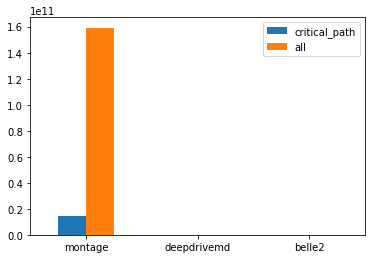

In [86]:
df_for_bar_plot = pd.DataFrame({'critical_path':[cp_val.sum()['weighted_access_size (sum)'], 0, 0],
                               'all': [df_montage.sum()['weighted_access_size (sum)'], 0, 0]},
                              index=['montage', 'deepdrivemd', 'belle2'])
df_for_bar_plot.plot.bar(rot=0)

In [41]:
"critical path: {0}, all: {1}".format(Utils.print_decimal(df_for_bar_plot['critical_path'][0]), 
                                      Utils.print_decimal(df_for_bar_plot['all'][0]))

'critical path: 13.16 GB, all: 148.25 GB'

In [43]:
dlife_montage.mismatch_rate(G_montage, rate='value', threshold=.9)

{'pposs2ukstu_blue_001_001.fits': {'in_rate': 918034560.0,
  'out_rate': 989696821.5,
  'in_edges': [('mProject (ID0000001)', 'pposs2ukstu_blue_001_001.fits')],
  'out_edges': [('pposs2ukstu_blue_001_001.fits', 'mDiffFit (ID0000018)'),
   ('pposs2ukstu_blue_001_001.fits', 'mDiffFit (ID0000019)'),
   ('pposs2ukstu_blue_001_001.fits', 'mDiffFit (ID0000020)'),
   ('pposs2ukstu_blue_001_001.fits', 'mDiffFit (ID0000024)'),
   ('pposs2ukstu_blue_001_001.fits', 'mDiffFit (ID0000030)'),
   ('pposs2ukstu_blue_001_001.fits', 'mDiffFit (ID0000031)'),
   ('pposs2ukstu_blue_001_001.fits', 'mDiffFit (ID0000021)'),
   ('pposs2ukstu_blue_001_001.fits', 'mDiffFit (ID0000017)'),
   ('pposs2ukstu_blue_001_001.fits', 'mDiffFit (ID0000023)'),
   ('pposs2ukstu_blue_001_001.fits', 'mDiffFit (ID0000027)'),
   ('pposs2ukstu_blue_001_001.fits', 'mDiffFit (ID0000025)'),
   ('pposs2ukstu_blue_001_001.fits', 'mDiffFit (ID0000029)'),
   ('pposs2ukstu_blue_001_001.fits', 'mDiffFit (ID0000026)'),
   ('pposs2ukstu_blu

In [46]:
leaf_node = dlife_montage.leaf_file_node(G_montage, attr_name='value')
leaf_node

{'cposs2ukstu_blue_001_004_area.fits': {'out_edges': OutEdgeDataView([]),
  'volume_used': 0},
 'cposs2ukstu_blue_002_004_area.fits': {'out_edges': OutEdgeDataView([]),
  'volume_used': 0},
 'cposs2ukstu_blue_003_004_area.fits': {'out_edges': OutEdgeDataView([]),
  'volume_used': 0},
 'cposs2ukstu_blue_004_004_area.fits': {'out_edges': OutEdgeDataView([]),
  'volume_used': 0},
 '1-mosaic_area.fits': {'out_edges': OutEdgeDataView([]), 'volume_used': 0}}

In [56]:
leaf_node_vol_sum = np.sum([Utils.get_file_node_volume(G_montage, x) for x in leaf_node.keys()])
"Leaf nodes: {0}, all: {1}".format(Utils.print_decimal(leaf_node_vol_sum, 
                    unit="GB", dec_len=3), Utils.print_decimal(df_for_bar_plot['all'][0]))

'Leaf nodes: 5.365 GB, all: 148.25 GB'

In [54]:
df_summary_montage = Utils.get_stat_info(df_montage)

/Users/leeh736/miniconda3/envs/plotly/lib/python3.7/site-packages/ipykernel_launcher.py:187: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


In [624]:
print_decimal(df_summary_montage.loc['weighted_access_size (sum)']['sum'])

'148.25 GB'

<AxesSubplot:>

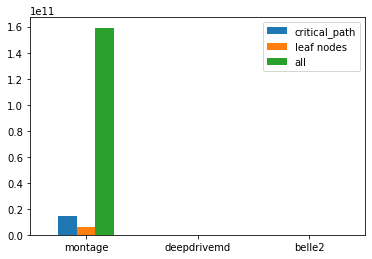

In [88]:
df_for_bar_plot = pd.DataFrame({'critical_path':[cp_val.sum()['weighted_access_size (sum)'], 0, 0],
                                'leaf nodes':[leaf_node_vol_sum, 0, 0],
                               'all': [df_montage.sum()['weighted_access_size (sum)'], 0, 0]},
                              index=['montage', 'deepdrivemd', 'belle2'])
df_for_bar_plot.plot.bar(rot=0)

In [59]:
prod_cons = dlife_montage.producer_consumer_tasks(G_montage)
prod_cons

[['mProject (ID0000001)',
  'pposs2ukstu_blue_001_001_area.fits',
  'mDiffFit (ID0000025)'],
 ['mProject (ID0000001)',
  'pposs2ukstu_blue_001_001.fits',
  'mDiffFit (ID0000025)'],
 ['mProject (ID0000001)',
  'pposs2ukstu_blue_001_001_area.fits',
  'mDiffFit (ID0000022)'],
 ['mProject (ID0000001)',
  'pposs2ukstu_blue_001_001.fits',
  'mDiffFit (ID0000022)'],
 ['mProject (ID0000001)',
  'pposs2ukstu_blue_001_001_area.fits',
  'mDiffFit (ID0000023)'],
 ['mProject (ID0000001)',
  'pposs2ukstu_blue_001_001.fits',
  'mDiffFit (ID0000023)'],
 ['mProject (ID0000001)',
  'pposs2ukstu_blue_001_001_area.fits',
  'mDiffFit (ID0000020)'],
 ['mProject (ID0000001)',
  'pposs2ukstu_blue_001_001.fits',
  'mDiffFit (ID0000020)'],
 ['mProject (ID0000001)',
  'pposs2ukstu_blue_001_001_area.fits',
  'mDiffFit (ID0000026)'],
 ['mProject (ID0000001)',
  'pposs2ukstu_blue_001_001.fits',
  'mDiffFit (ID0000026)'],
 ['mProject (ID0000001)',
  'pposs2ukstu_blue_001_001_area.fits',
  'mDiffFit (ID0000019)'],
 [

In [61]:
def get_produced_volumes(G, prod_cons, attr_name='value'):
    ret = []
    for prod_con in prod_cons:
        for p, d, attr in G.edges(prod_con[0], data=True):
            if d == prod_con[1]:
                ret.append(attr[attr_name])
                break

    return ret

def get_consumed_volumes(G, prod_cons, attr_name='value'):
    ret = []
    for prod_con in prod_cons:
#        print(prod_con)
        for d, c, attr in G.in_edges(prod_con[2], data=True):
#            print(p,d)
            if d == prod_con[1]:
                ret.append(attr[attr_name])
                break
    return ret

In [62]:
pv = get_produced_volumes(G_montage, prod_cons[:10])
pv

[920144787,
 918034560,
 920144787,
 918034560,
 920144787,
 918034560,
 920144787,
 918034560,
 920144787,
 918034560]

In [685]:
cv = get_consumed_volumes(G_montage, prod_cons[:10])
cv

[1176348384,
 977253384,
 1176348384,
 977253384,
 1176348384,
 1176348384,
 1176348384,
 977253384,
 1176348384,
 977253384]

In [74]:
f_nodes = [f_node for producer, f_node, consumer in prod_cons]
f_node_counts = Counter(f_nodes)
f_node_counts.most_common(10)

[('mAdd (ID0000156)', 48),
 ('pposs2ukstu_blue_001_001_area.fits', 16),
 ('pposs2ukstu_blue_001_001.fits', 16),
 ('pposs2ukstu_blue_001_002_area.fits', 16),
 ('pposs2ukstu_blue_001_002.fits', 16),
 ('pposs2ukstu_blue_001_003_area.fits', 16),
 ('pposs2ukstu_blue_001_003.fits', 16),
 ('pposs2ukstu_blue_001_004.fits', 16),
 ('pposs2ukstu_blue_001_004_area.fits', 16),
 ('pposs2ukstu_blue_002_001_area.fits', 16)]

In [97]:
df_concat = Utils.count_overlap(df_belle2, 'twoPhoton_ECL-phase3-optimized.root')

In [98]:
df_concat.sort_values(by='overlap_count', ascending=False)[:20]

,fname,offset,access_size,extra1,extra2,offset_end,overlap_count,task_name
3682,twoPhoton_ECL-phase3-optimized.root,5132542,1013,0,0,5133555,469,1
3682,twoPhoton_ECL-phase3-optimized.root,5132542,1013,0,0,5133555,469,set15
3682,twoPhoton_ECL-phase3-optimized.root,132737,959,0,0,133696,469,set2
3682,twoPhoton_ECL-phase3-optimized.root,1257452,420,0,0,1257872,469,set10
3682,twoPhoton_ECL-phase3-optimized.root,1722994,10124,0,0,1733118,469,set12
3682,twoPhoton_ECL-phase3-optimized.root,2960686,10809,0,0,2971495,469,set3
3682,twoPhoton_ECL-phase3-optimized.root,416513,2487,0,0,419000,469,set19
3682,twoPhoton_ECL-phase3-optimized.root,290647,26328,0,0,316975,469,set9
3682,twoPhoton_ECL-phase3-optimized.root,1820805,605,0,0,1821410,469,set0
3682,twoPhoton_ECL-phase3-optimized.root,552254,9500,0,0,561754,469,set8


<BarContainer object of 10 artists>

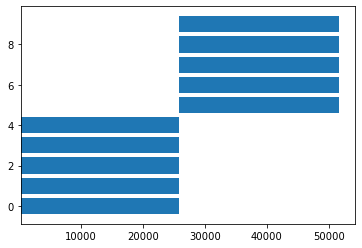

In [78]:
_df = df_concat[df_concat['task_name'] == 'set13'].sort_values(by='offset')[6:16]
plt.barh(y=[x for x in range(10)], width=_df['access_size'], left=_df['offset'])

<BarContainer object of 10 artists>

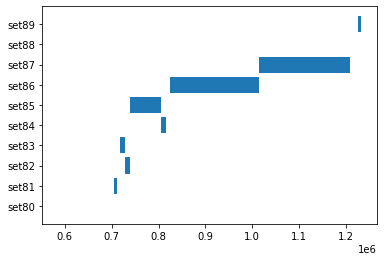

In [84]:
tmp =  df_concat[100:200]
tmp_len=10
plt.barh(y=[tmp['task_name'].iloc[0] + str(x) for x in range(tmp_len)], width=tmp[0:tmp_len]['access_size'], left=tmp[0:tmp_len]['offset'])
#plt.barh(y=[str(x) for x in tmp[0:tmp_len].index], width=tmp[0:tmp_len]['access_size'], left=tmp[0:tmp_len]['offset'])
#plt.barh(y=[x for x in range(tmp_len)], width=tmp[0:tmp_len]['access_size'], left=tmp[0:tmp_len]['offset'])